In [24]:
%pylab inline
import numpy as np
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load the MassiveNuS convergence dataset

See http://www.columbialensing.org/#massivenus for more information

## Shape catalog

From the HSC-XMM field shape catalog generate:
- noise covariance matrix
- survey mask
- e1, e2 maps

In [25]:
from astropy.table import Table
from astropy.io import fits

In [26]:
cat = Table.read('../data/193145.fits')

In [54]:
#cat.keys()

In [28]:
survey_cut = (cat['ira']>35.5) * (cat['ira']<38.5) * (cat['idec']>-6) * (cat['idec']<-3)

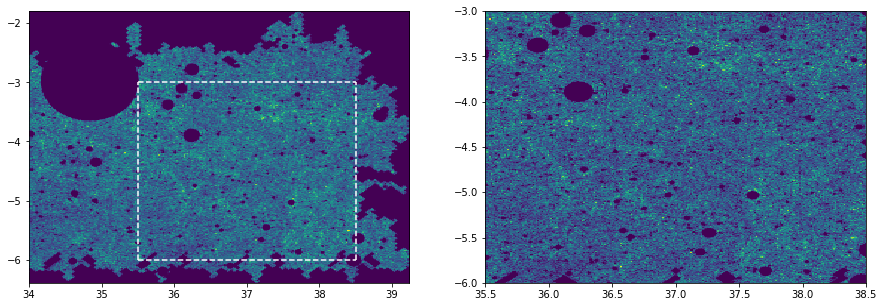

In [29]:
figure(figsize=[15,5])
subplot(121)
hist2d(cat['ira'], cat['idec'], 256);
hlines(y=-3,xmin=35.5, xmax=38.5, color='w', linestyle='--')
hlines(y=-6,xmin=35.5, xmax=38.5, color='w', linestyle='--')
vlines(x=35.5,ymin=-6, ymax=-3, color='w', linestyle='--')
vlines(x=38.5,ymin=-6, ymax=-3, color='w', linestyle='--')
subplot(122)
hist2d(cat['ira'][survey_cut], cat['idec'][survey_cut], 256);

cat = cat[survey_cut]

Ensure that our assumption of redshift mean is correct

Mean redshift 0.9701822


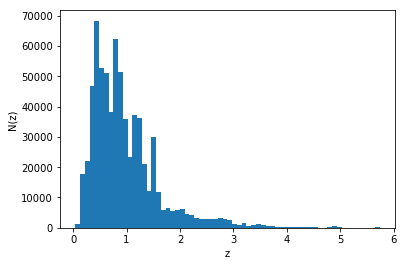

In [30]:
hist(cat['photoz_best'], 64);
xlabel('z')
ylabel('N(z)')
print('Mean redshift', np.mean(cat['photoz_best']))

Bin the catalog using [lenspack](https://github.com/CosmoStat/lenspack/tree/master/lenspack).

In [31]:
from lenspack.utils import bin2d

# Compute boundaries of the field so that it fits in a 360x360 map
# MassiveNuS maps beging 512x512 with 0.4 arcmin resolution, we resize them to 360x360
resolution = 512/360*0.4
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel
width = 360
size = width * resolution / 60.

ra = median(cat['ira'])
dec = median(cat['idec'])
extent = [ra - size/2, ra + size/2, dec - size/2, dec + size/2]

**Number of galaxy per pixel map**

In [32]:
from quarks2cosmos.utils import get_extend_radec

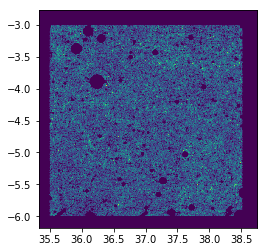

In [33]:
n_gal_map = bin2d(cat['ira'], cat['idec'],
                  npix=width,
                  extent=extent)

imshow(n_gal_map, origin='lower', extent=get_extend_radec(resolution, width,ra, dec))

**Survey mask**

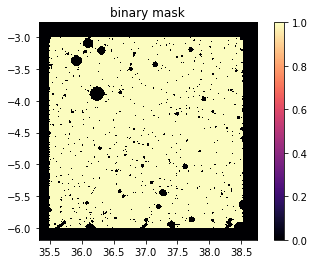

In [34]:
m = n_gal_map == 0
mask = 1.-m
imshow(mask, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
colorbar()
#xlim(gca().get_xlim()[::-1])
title("binary mask")

mask = np.expand_dims(mask, -1)

**Ellipticity maps**

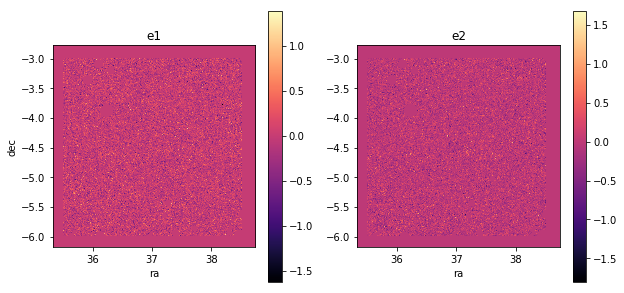

In [35]:
# Bin ellipticity components based on galaxy position into a 360x360 map
e1map, e2map = bin2d(cat['ira'], cat['idec'], 
                     v=(cat['ishape_hsm_regauss_e1'], cat['ishape_hsm_regauss_e2']), 
                     npix=width,
                     extent=extent)

figure(figsize=[10,5])
subplot(121)
imshow(e1map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
#xlim(gca().get_xlim()[::-1])
colorbar()
xlabel('ra')
ylabel('dec')
title('e1')

subplot(122)
imshow(e2map, cmap='magma', origin='lower', extent=get_extend_radec(resolution, width, ra, dec))
colorbar()
#xlim(gca().get_xlim()[::-1])
xlabel('ra')
title('e2')

meas_shear = np.stack([e1map, e2map], axis=-1)

**Noise covariance matrix**

/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/gpfslocalsup/pub/anaconda-py3/2020.02/envs/tensorflow-gpu-2.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5,1,'$\\sigma_{e_2}/\\sqrt{N_{gal}}$')

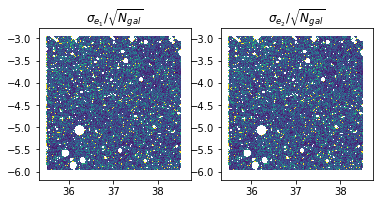

In [36]:
sigma_e1 = np.std(cat['ishape_hsm_regauss_e1'])/np.sqrt(n_gal_map)
sigma_e2 = np.std(cat['ishape_hsm_regauss_e2'])/np.sqrt(n_gal_map)

subplot(121)
imshow(sigma_e1, extent=get_extend_radec(resolution, width, ra, dec))
title(r'$\sigma_{e_1}/\sqrt{N_{gal}}$')

subplot(122)
imshow(sigma_e2, extent=get_extend_radec(resolution, width, ra, dec))
title(r'$\sigma_{e_2}/\sqrt{N_{gal}}$')

## Kaiser-Squires solution

Use the first mass-mapping technique [Kaiser-Squires (1993)](https://ui.adsabs.harvard.edu/abs/1993ApJ...404..441K/abstract). Smooth the solution with a gaussian filter.

In [37]:
from quarks2cosmos.lensing import ks93, ks93inv
from scipy.ndimage import gaussian_filter

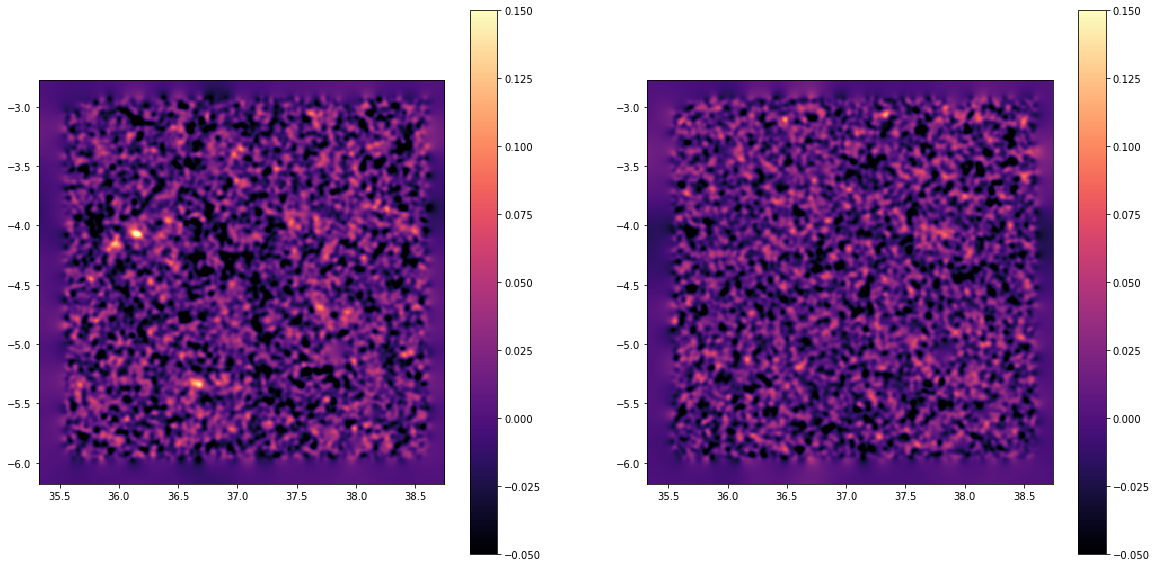

In [38]:
kappaE, kappaB = ks93(e1map, e2map)

kwargs = dict(vmin=-.05, vmax=.15, cmap='magma', extent=get_extend_radec(resolution, width, ra, dec))
figure(figsize=[20,10])
subplot(121)
imshow(gaussian_filter(kappaE,2)[:,::-1], **kwargs);colorbar()
subplot(122)
imshow(gaussian_filter(kappaB,2)[:,::-1], **kwargs);colorbar()

## Wiener filter solution

Get the maximum-a-posteriori (MAP), assuming a Gaussian prior that is characterised by the theoretical power spectrum.

1) The likelihood

In [39]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x[...,0].reshape((360, 360))
    kb = x[...,1].reshape((360, 360))
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    return - jnp.sum(mask*(model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

2) Build a Gaussian prior from the Power Spectrum (computed from [jax-cosmo](https://github.com/DifferentiableUniverseInitiative/jax_cosmo))

Text(0,0.5,'$C_\\ell$')

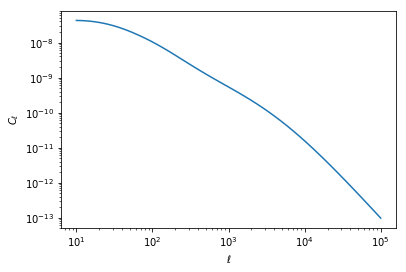

In [40]:
# import the theoretical power spectrum
ps_data_th = np.load('../data/ktng_PS_theory.npy').astype('float32')
loglog(ps_data_th[0,:], ps_data_th[1,:])
xlabel(r'$\ell$')
ylabel(r'$C_\ell$')

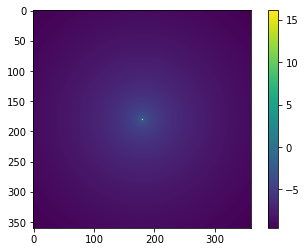

In [50]:
from quarks2cosmos.lensing import make_power_map

power_map_th = np.array(make_power_map(ps_data_th, size=360, pixel_size=pixel_size, ell=True))
imshow(np.log(jnp.fft.fftshift(power_map_th))); colorbar();

In [51]:
def log_gaussian_prior(map_data, sigma, ps_map):
    """
    map_data: array on which to evaluate the log prior
    sigma: temperature
    ps_map: 
    """
    map_data = map_data[...,0].reshape(360, 360)
    data_ft = jnp.fft.fft2(map_data) / 360.
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

3) Compute the MAP

In [43]:
from functools import partial

def log_posterior(x, sigma, ps_map, meas_shear, mask):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(x, sigma, power_map_th)
    return (data_score + gaussian_score).reshape(-1, 360*360*2)

log_posterior = partial(log_posterior, ps_map=power_map_th, meas_shear=meas_shear, mask=mask)

In [55]:
x = np.expand_dims(np.stack([kappaE, kappaB], -1),0)
print(x.shape)
gaussian_prior_score(x, np.zeros((1,1,1)), power_map_th).shape

(1, 360, 360, 2)


(1, 360, 360, 2)

In [45]:
sigma = np.std(np.concatenate([cat['ishape_hsm_regauss_e1'], cat['ishape_hsm_regauss_e2']])) / np.mean(n_gal_map * mask)
print(sigma)

0.09762570930189919


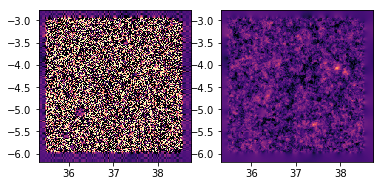

In [53]:
subplot(121)
imshow(x[0,...,0],**kwargs)
subplot(122)


imshow(x[0,...,0] + sigma**2 * gaussian_prior_score(x, sigma*np.ones((1,1,1)), power_map_th)[0,...,0],**kwargs)